# Abstract

In this blog post, I implemented a classification system based on loans that finds an optimal profit for a bank. But through this exploration, I also visualize how these systems can affect the borrower negatively and how it touches on the issues of fairness. How do we balance efficient and "optimal" systems that benefit the institutions in power, but also understand how they can perpetuate oppression and unfairness? By using Logistic Regression and finding the best features to train on, I was able to find the ideal threshold for the probability of repayment, which determines which borrowers have access to credit. Once finding the optimal weight and threshold, I see the implications of this threshold both on the banks and the borrowers, and how from differing perspectives, the same outcomes can have completely different meanings of fairness. I was able to find that the optimal threshold score is 0.53, and that the bank's optimal profit is $32,368,726.

# Grabbing and exploring the data

First I need to download the training data:

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv"
df_train = pd.read_csv(url)

In [6]:
df_train

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,25,43200,RENT,NaN,VENTURE,B,1200,9.91,0,0.03,N,4
1,27,98000,RENT,3.0,EDUCATION,C,11750,13.47,0,0.12,Y,6
2,22,36996,RENT,5.0,EDUCATION,A,10000,7.51,0,0.27,N,4
3,24,26000,RENT,2.0,MEDICAL,C,1325,12.87,1,0.05,N,4
4,29,53004,MORTGAGE,2.0,HOMEIMPROVEMENT,A,15000,9.63,0,0.28,N,10
...,...,...,...,...,...,...,...,...,...,...,...,...
26059,36,150000,MORTGAGE,8.0,EDUCATION,A,3000,7.29,0,0.02,N,17
26060,23,48000,RENT,1.0,VENTURE,A,4325,5.42,0,0.09,N,4
26061,22,60000,RENT,0.0,MEDICAL,B,15000,11.71,0,0.25,N,4
26062,30,144000,MORTGAGE,12.0,PERSONAL,C,35000,12.68,0,0.24,N,8


We can start exploring the data. Let's look at how the home ownership type is broken down with the different types of loans for housing:

In [7]:
summaryTable = df_train.groupby(['person_home_ownership']).aggregate(Loan_Average =('loan_percent_income', 'mean'))
summaryTable

,Loan_Average
person_home_ownership,
MORTGAGE,0.151560
OTHER,0.194432
OWN,0.188800
RENT,0.181819


It seems like the loan percentage is lowest for mortgages. Those who already have a mortgage or own houses are more likely to need less as a percentage of their total wealth for loans and have more security in their wealth.

We can also visualize this data:

[Text(0.5, 0, 'House Ownership type'),
 Text(0, 0.5, 'Income percentile'),
 Text(0.5, 1.0, 'House ownership vs Income percentile')]

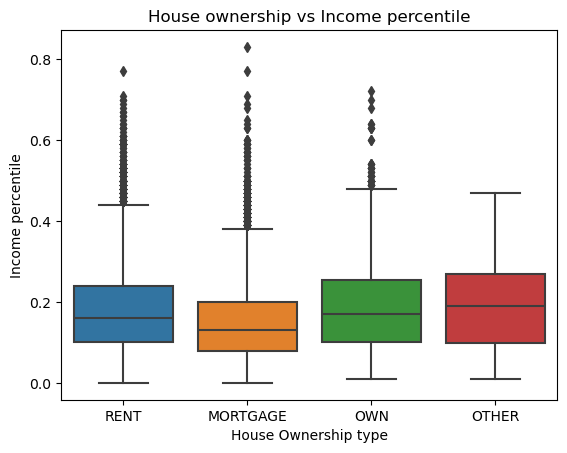

In [20]:

# plot
sns.boxplot(df_train, x='person_home_ownership', y='loan_percent_income').set(xlabel ="House Ownership type", ylabel = "Income percentile", title ='House ownership vs Income percentile')

Interestingly, the boxplot shows us that generally those who already own property will take loans as more of a percentage of their income. Interestingly, the mortgages has less percentage of income to go towards loans. If someone is already willing to spend money on a mortgage, they have more income to spare.

We can also look at age and see whether or not the bank determines if the loan is likely to be repaid depending on this factor. First we can copy our data and create quartiles of ages .

/Users/jakegilbert/anaconda3/envs/ml-0451/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


[Text(0.5, 0, 'Age quartile'),
 Text(0, 0.5, 'Loan amount ($)'),
 Text(0.5, 1.0, 'Age quartile vs Amount Received in Loans')]

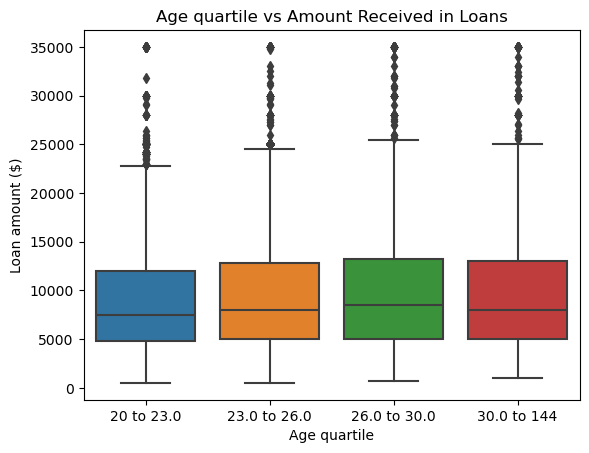

In [21]:
df_age_c = df_train.copy()

quartiles = df_age_c['person_age'].quantile([0.25, 0.5, 0.75])
q1 = f"{df_age_c['person_age'].min()} to {quartiles[0.25]}"
q2 = f"{quartiles[0.25]} to {quartiles[0.50]}"
q3 = f"{quartiles[0.50]} to {quartiles[0.75]}"
q4 = f"{quartiles[0.75]} to {df_age_c['person_age'].max()}"
df_age_c['age_quartile'] = pd.qcut(df_train['person_age'], q = [0, 0.25, 0.5, 0.75, 1], labels = [q1, q2, q3, q4])

# now we can plot
sns.boxplot(df_age_c, x='age_quartile', y='loan_amnt').set(xlabel ="Age quartile", ylabel = "Loan amount ($)", title ='Age quartile vs Amount Received in Loans')

While there is not much change in the ages of how much income you spend on loans, maybe a better metric is to see the time spend employed to how much one is willing to spend loans as a percentage of their income. We will do the same quartile method:

/Users/jakegilbert/anaconda3/envs/ml-0451/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


[Text(0.5, 0, 'Employment length quartile'),
 Text(0, 0.5, 'Amount received in loans'),
 Text(0.5, 1.0, 'Employment quartile vs Amount received in loans')]

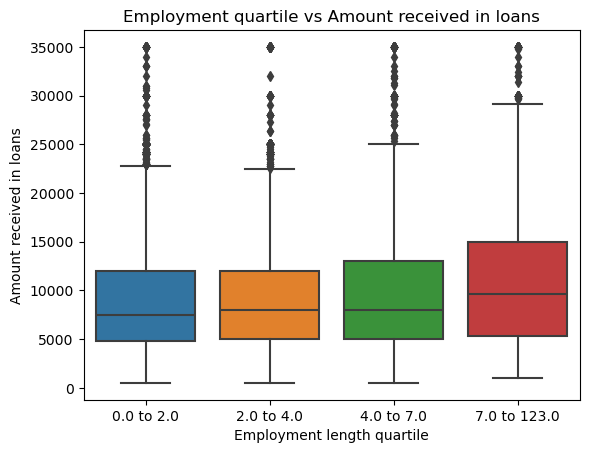

In [22]:
df_train_emp = df_train.copy()

quartiles = df_train_emp['person_emp_length'].quantile([0.25, 0.5, 0.75])
q1 = f"{df_train_emp['person_emp_length'].min()} to {quartiles[0.25]}"
q2 = f"{quartiles[0.25]} to {quartiles[0.50]}"
q3 = f"{quartiles[0.50]} to {quartiles[0.75]}"
q4 = f"{quartiles[0.75]} to {df_train_emp['person_emp_length'].max()}"
df_train_emp['employment_length_quartile'] = pd.qcut(df_train_emp['person_emp_length'], q = [0, 0.25, 0.5, 0.75, 1], labels = [q1, q2, q3, q4])

sns.boxplot(df_train_emp, x='employment_length_quartile', y='loan_amnt').set(xlabel ="Employment length quartile", ylabel = "Amount received in loans", title ='Employment quartile vs Amount received in loans')


From this boxplot, we can see that people that have been working for longer are more willing to take more money out in loans. The change is gradual, but there is a large difference between the two ranges, meaning the data deals with a wide range of circumstances.

# Building the Model

We will implement Logistic Regression and use cross validation to determine the 5 best features and prevent overfitting.

We also want to use a labelEncoder to label non-numeric data as numeric values so it can be fit with Logistic Regression. I also need to drop NA values

In [11]:
df_LR = df_train.copy()
df_LR.drop(columns = 'loan_grade', inplace = True)

# Also get rid of outlier in age feature
df_LR = df_LR[df_LR['person_age'] != 144]

# getting all columns (features)
df_LR = df_LR[list(df_LR.columns)]


# Need to encode features that are not numeric
# home_ownership, loan_intent, default_on_file

encoder = LabelEncoder()

encoder.fit(df_LR['person_home_ownership'])
df_LR['person_home_ownership'] = encoder.transform(df_LR['person_home_ownership'])

encoder.fit(df_LR['loan_intent'])
df_LR['loan_intent'] = encoder.transform(df_LR['loan_intent'])

encoder.fit(df_LR['cb_person_default_on_file'])
df_LR['cb_person_default_on_file'] = encoder.transform(df_LR['cb_person_default_on_file'])

df_LR = df_LR.dropna()
df_LR['person_emp_length'] = df_LR['person_emp_length'].astype(int)

df_LR.head()


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1,27,98000,3,3,1,11750,13.47,0,0.12,1,6
2,22,36996,3,5,1,10000,7.51,0,0.27,0,4
3,24,26000,3,2,3,1325,12.87,1,0.05,0,4
4,29,53004,0,2,2,15000,9.63,0,0.28,0,10
6,21,21700,3,2,2,5500,14.91,1,0.25,0,2


Now with our cleaned up data, I want to find the combination of the 5 best features by calculating the score:

In [12]:
# train model based on five columns and choose best one
bestScore = 0
BestFeatures = []

#Get all columns and remove target
columns = list(df_LR.columns)
columns.remove('loan_status')

for feat in combinations(columns, 5):
    
    features = list(feat)

    LR = LogisticRegression(max_iter=2000)

    LR.fit(df_LR[features], df_LR['loan_status'])

    score = LR.score(df_LR[features], df_LR['loan_status'])

    if score > bestScore:
      bestScore = score
      BestFeatures = features

Now we can see which combination of 5 features gives us the best score for Linear Regression:

In [13]:
print("The best score: ", bestScore)
print("Best features: ", BestFeatures)

The best score:  0.8462277331470486
Best features:  ['person_age', 'person_home_ownership', 'person_emp_length', 'loan_percent_income', 'cb_person_cred_hist_length']


We can also do cross validation to see if there is any overfitting:

In [14]:
cross_val_scores = cross_val_score(LR, df_LR[features], df_LR['loan_status'], cv=5)
#print((cv_scores_LR).mean())
cross_val_scores.mean()

0.795973448332728

Our cross validation mean gives us 80% accuracy with the best features being age, income, home ownership, loan intent and loan status.

We need to train our model then get the weight vector:

In [15]:
# train
LR.fit(df_LR[BestFeatures], df_LR['loan_status'])

#print weight vector for all features
print(LR.coef_[0])

[-8.07133566e-04  3.36542470e-01 -1.99919415e-02  7.93852091e+00
 -1.88709181e-03]


# Finding a threshold

We have trained a Logistic Regression model and have a weight vector, and now we need to find a suitable threshold which determines our target value — whether someone is likely to default on a loan.

We have a couple assumptions to determine a bank's profit:

If the loan is repaid in full, the profit for the bank is equal to loan_amnt*(1 + 0.25*loan_int_rate)**10 - loan_amnt
OR
If the borrower defaults on the loan, the “profit” for the bank is equal to loan_amnt*(1 + 0.25*loan_int_rate)**3 - 1.7*loan_amnt

Since we need to find a feature that will pass this threshold, a good option is to calculate whether the probability of an individual pays their loans back passes the threshold. We can use the predict_proba function with our model and add it to our dataframe:

A way to find an optimal threshold is to graph an expected gain.

In [16]:
proba_pay = LR.predict_proba(df_LR[BestFeatures]) # method courtesy of Mihir Singh
df_LR['proba_pay'] = proba_pay[:,0].tolist()

Now we can use expected gain to find the optimal threshold by graphing it based on the bank profit, using the two aforementioned assumptions/equations:

In [17]:
def getProfit(t, df):

    #new dataframe for any row that is above threshold
    df_thresh = df_LR[df_LR['proba_pay'] > t].copy()

    profit = 0
    #default = 0

    for i in range(len(df_thresh)):

        # if NOT DEFAULTED
        if df_thresh.iloc[i]['loan_status'] == 0:
            profit += df_thresh.iloc[i]['loan_amnt'] * (1 + 0.25 *  (df_thresh.iloc[i]['loan_int_rate'] / 100))**10 - (df_thresh.iloc[i]['loan_amnt'])
        else:
            profit += df_thresh.iloc[i]['loan_amnt'] * (1 + 0.25 * (df_thresh.iloc[i]['loan_int_rate'] /100)) **3 - (1.7 * df_thresh.iloc[i]['loan_amnt']) 
    return profit

In [ ]:
thresholds = np.linspace(0, 1, 100)
profits = []
for t in thresholds:
    profits.append(getProfit(t, df_LR))

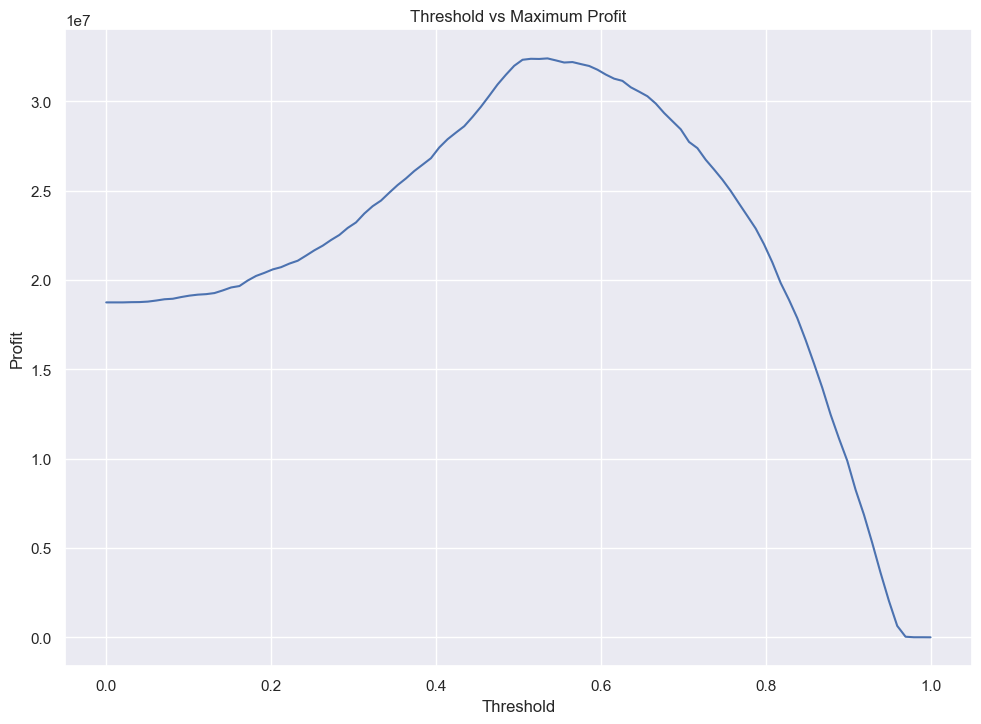

<Figure size 1000x600 with 0 Axes>

In [28]:
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})
plt.title("Threshold vs Maximum Profit")
plt.xlabel("Threshold")
plt.ylabel("Profit")
plt.plot(thresholds, profits)
plt.figure(figsize=(10, 6))
plt.show()

Our threshold for maximum profit converges at a highest point in between 0.4 and 0.5, and we can extract the exact value, the total profit at that threshold and the profit per borrower:

In [ ]:
print("Max threshold: ", profits.index(max(profits)) / 100)
print(f"Max profit at ideal threshold: ${int(max(profits))}")
print(f"Profit per borrower: ${max(profits) / len(df_LR[df_LR['proba_pay'] >= 0.53])}")

Max threshold:  0.53
Max profit at ideal threshold: $32406222
Profit per borrower: $1566.9562640408653


# Evaluating from bank's perspective

Now that we have an optimal weight and threshold, we can explore the profit on some test data:

In [30]:
# import data
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/test.csv"
df_test_original = pd.read_csv(url)


#clean up data
df_test = df_test_original.copy()
df_test.drop(columns = 'loan_grade', inplace = True)
df_test = df_test[df_test['person_age'] != 144]


# Like before, use Label Encoder so Logistic Regression can evaluate with numeric labels
encoder = LabelEncoder()

encoder.fit(df_test['cb_person_default_on_file'])
df_test['cb_person_default_on_file'] = encoder.transform(df_test['cb_person_default_on_file'])

encoder.fit(df_test['loan_intent'])
df_test['loan_intent'] = encoder.transform(df_test['loan_intent'])

encoder.fit(df_test['person_home_ownership'])
df_test['person_home_ownership'] = encoder.transform(df_test['person_home_ownership'])



df_test = df_test.dropna()
df_test['person_emp_length'] = df_test['person_emp_length'].astype(int)



Like before, we will create a new column to determine the probability that someone will pay based on the best features chosen when we compared the scores

In [31]:
BestFeatures

['person_age',
 'person_home_ownership',
 'person_emp_length',
 'loan_percent_income',
 'cb_person_cred_hist_length']

In [32]:
proba_pay = LR.predict_proba(df_test[BestFeatures])
df_test['proba_pay'] = proba_pay[:,0].tolist()

#FIND PROFITS with our threshold of 0.53 and new dataframe
test_profit = getProfit(0.53, df_test)

print(f"with a threshold of 0.53, the total bank profit: ${test_profit}")
print(f"profit per borrower: ${test_profit / len(df_test[df_test['proba_pay'] >= 0.53])}")

df_test.head()




with a threshold of 0.53, the total bank profit: $32368726.934103493
profit per borrower: $6309.693359474365


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,proba_pay
0,21,42000,3,5,5,1000,15.58,1,0.02,0,4,0.907719
1,32,51000,0,2,0,15000,11.36,0,0.29,0,9,0.752253
2,35,54084,3,2,0,3000,12.61,0,0.06,0,6,0.872545
3,28,66300,0,11,3,12000,14.11,1,0.15,0,6,0.916299
4,22,70550,3,0,3,7000,15.88,1,0.08,0,3,0.846674


# Evaluating the model from the borrower's perspective

Given the bank's perspective, its profit and profit per borrower, we can also use the data to explore the effects on the borrower.

1. Firstly, we can examine how difficult it is for certain age groups to get access to credit. In order to do this, we can create a plot of the probability that each age group will pay.

Like before, we also move ages into groups using quartiles:

/Users/jakegilbert/anaconda3/envs/ml-0451/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


Text(0.5, 0, 'Age group quartiles')

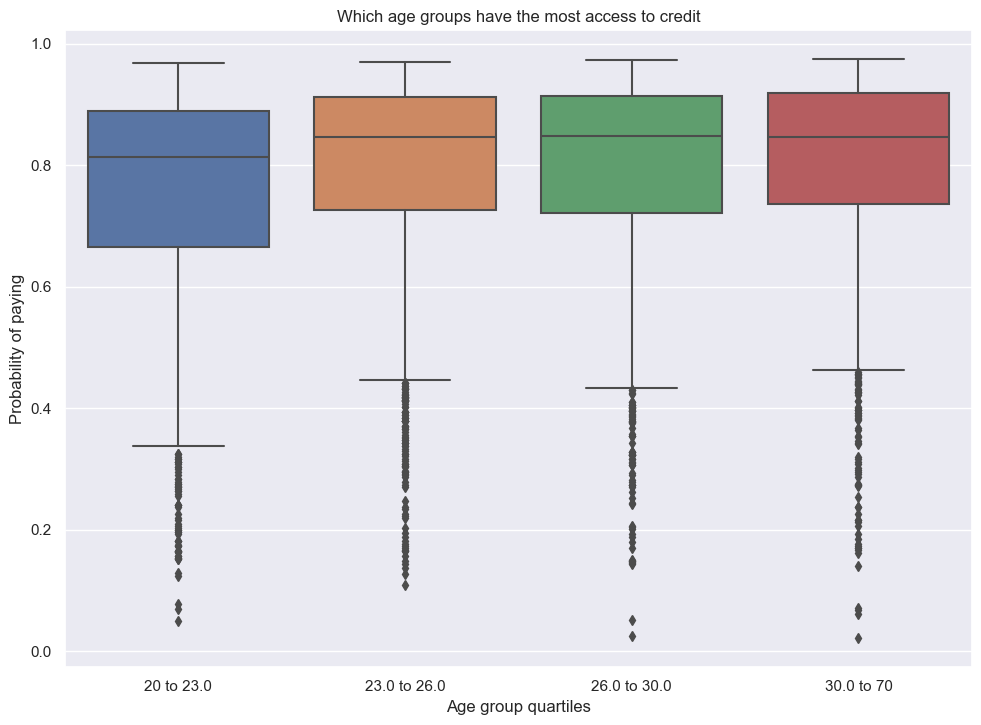

In [33]:
# group individuals into quartiles by age
quartiles = df_test['person_age'].quantile([0.25, 0.5, 0.75])

q1 = f"{df_test['person_age'].min()} to {quartiles[0.25]}"
q2 = f"{quartiles[0.25]} to {quartiles[0.50]}"
q3 = f"{quartiles[0.50]} to {quartiles[0.75]}"
q4 = f"{quartiles[0.75]} to {df_test['person_age'].max()}"

# separate individuals into quartiles
df_test['age_groups'] = pd.qcut(df_test['person_age'], q = [0, 0.25, 0.5, 0.75, 1], labels = [q1, q2, q3, q4])

# plot
sns.boxplot(x=df_test['age_groups'], y=df_test['proba_pay'])
plt.title('Which age groups have the most access to credit')
plt.ylabel('Probability of paying')
plt.xlabel('Age group quartiles')

Based on our plot, it seems that younger people are more likely to be denied credit and therefore have less access. After the youngest group, there is little difference between ages 23 and older.

2. Next we will look at the difficulty of getting loans for medical expenses compared to other reasons, including business or education.

For this, we will decode the loan intent and group by each loan intent label to see loan status and the rate of acceptance given the Logistic Regression probability

In [ ]:
df_medical = df_test.copy()
df_medical['loan_intent'] = df_test_original['loan_intent']

# make new column for all those who are accepted for loans based on if they pass the threshold
df_medical['get_loans'] = df_medical['proba_pay'] > 0.53
get_loans = df_medical.groupby('loan_intent')['get_loans'].mean()

# another column based on actual loan status (did they default or repay)
df_medical['repay_loans'] = df_medical['loan_status'] == 0
repay = df_medical.groupby('loan_intent')['repay_loans'].mean()


pd.DataFrame({'loans approved': get_loans, 'loans repaid': repay})

,loans approved,loans repaid
loan_intent,,
DEBTCONSOLIDATION,0.884956,0.712389
EDUCATION,0.897109,0.832483
HOMEIMPROVEMENT,0.933442,0.750000
MEDICAL,0.876048,0.715750
PERSONAL,0.890782,0.779559
VENTURE,0.903527,0.853734


Out of all of the intents, medical loans have the least likelihood to get approved, whereas home improvement is the highest. While the difference is not drastic, medical loans are noticeably more likely to default—along with dept consolidation—compared to other loans. This may be due to the fact that medical loans and debt consolidation are done out of necessity and often lead to default more often, so they are harder to access.

3. The last experiment is to see how a person's income level can affect how much they have access to credit given out model.

Similar to ages, we will use quartiles to group into 4 income categories then make a box plot:



/Users/jakegilbert/anaconda3/envs/ml-0451/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


Text(0.5, 0, 'Income group quartiles')

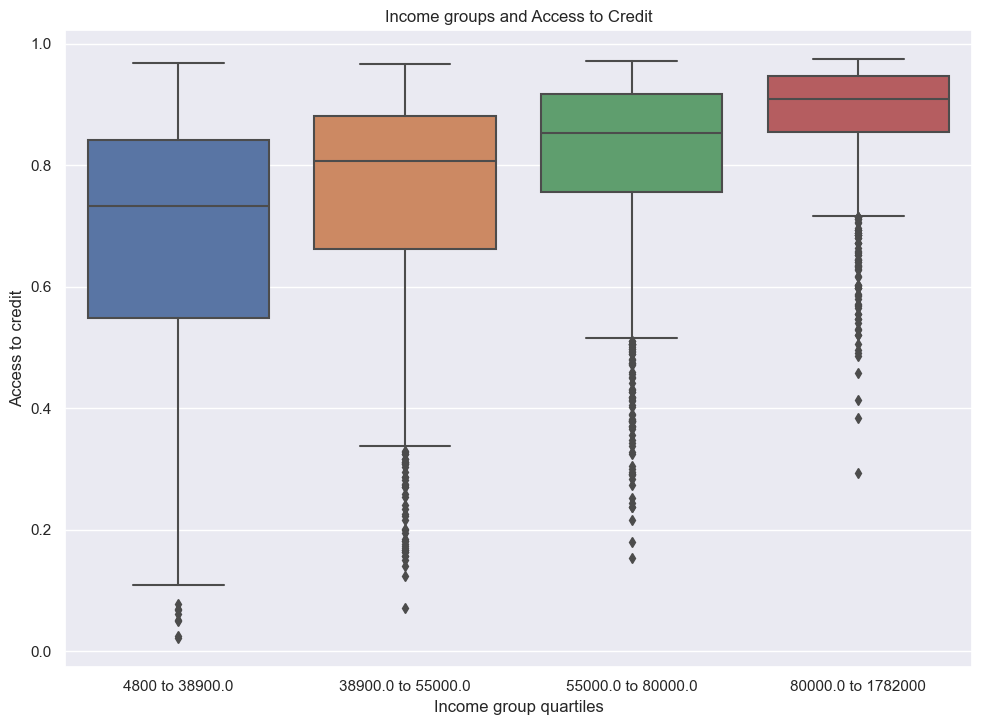

In [34]:
quartiles = df_test['person_income'].quantile([0.25, 0.5, 0.75])

q1 = f"{df_test['person_income'].min()} to {quartiles[0.25]}"
q2 = f"{quartiles[0.25]} to {quartiles[0.50]}"
q3 = f"{quartiles[0.50]} to {quartiles[0.75]}"
q4 = f"{quartiles[0.75]} to {df_test['person_income'].max()}"
df_test['income_groups'] = pd.qcut(df_test['person_income'], q = [0, 0.25, 0.5, 0.75, 1], labels = [q1, q2, q3, q4])

# plot
sns.boxplot(x=df_test['income_groups'], y=df_test['proba_pay'])
plt.title('Income groups and Access to Credit')
plt.ylabel('Access to credit')
plt.xlabel("Income group quartiles")

We can see there is a gradual but noticeable trend of access to credit for higher income groups. Those with money already available to spend can afford to take the risk of paying out later.

# Discussion

In the end, by training our model, we were able to determine on the test set that the optimal threshold score is 0.53, and that the bank's optimal profit is $32,368,726, given the risk of default. One fundamental question to address given the exploration is how fair this system of loans is or if it perpetuates existing systems of class oppression and income inequality. Looking at our 2nd exploration of the borrow's perspective, medical loans are much harder to access. On the surface, this makes sense because they are usually at risk of default more than other loans. However, in the following exploration, we were clearly able to see how access to credit  benefited the wealthy and groups with higher income than lower income groups. This means that not all groups are affected equally in this disparity for medical loans. Certain systems that seem "fair" and based off of a blanket meritocracy sometimes underneath are only perpetuating systems that benefit the already powerful. For medical loans, it is never the borrowers "fault" that they got hurt, but are often punished in the process, yet from the bank's perspective, the only loss is profit. At a narrow view of fairness, this system makes sense, where these systems are merely a side effect of given trends. A wider view of fairness would tell us it would benefit us to try to see the benefits of changing our loan systems from reasons that are born out of fairness, not profit incentive.

In the end, the loans that are the riskiest are often the ones that are the most needed and vital for the wellbeing of people. In this case, I don't think this system is fair—it punishes those who are already at a disadvantage.